## Part VII : Implementing Wavenet style structure

Wavenet Paper : [link](https://arxiv.org/pdf/1609.03499)

In [18]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# excetions show up normally
%xmode plain

# plots show up inline
%matplotlib inline

def get_device(no_gpu=False):
    """
    Returns one of cuda / mps / cpu based on availablity
    """
    if no_gpu is True:
        return torch.device("cpu")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Choose the default device
no_gpu = False
default_device = get_device(no_gpu)


# Needed to import modules from src
import sys
sys.path.append('..')


# Get Project Root (needed for reading config)
import os
projectRoot = os.path.dirname(os.getcwd())
print(projectRoot)

from src.loadData import loadData
import src.utils as utils

all_data = loadData(projectRoot)
vocab = utils.get_vocab(all_data)
print(f"Vocab Length:{len(vocab)}")

encode, decode = utils.get_encode_decode(vocab)
print(f"Encode test: {encode("emma")}\tDecode test: {decode(encode("emma"))}")
# print(f"Encode test: {encode("e")}\tDecode test: {decode(encode("e"))}")

train_percentage = 0.8
train_boundary = math.ceil(len(all_data) * train_percentage)

cv_percentage = train_percentage + 0.1
cv_boundary = math.ceil(len(all_data) * cv_percentage)

train_data = all_data[:train_boundary]
cv_data = all_data[train_boundary:cv_boundary]
test_data = all_data[cv_boundary:]

print(f"Name Counts ==> All:{len(all_data)}\tTrain:{len(train_data)}\t Validation:{len(cv_data)}\tTest: {len(test_data)} ")

Exception reporting mode: Plain
e:\Karpathy-Makemore
Vocab Length:27
Encode test: [5, 13, 13, 1]	Decode test: emma
Name Counts ==> All:32033	Train:25627	 Validation:3203	Test: 3203 


#### Create Samples from Data

In [19]:
import src.utils as utils

context_length = 8

xtr, ytr = utils.get_samples(train_data, encode, context_size=context_length)
Xtr, Ytr = torch.tensor(xtr, device=default_device), torch.tensor(ytr, device=default_device)

xcv, ycv = utils.get_samples(cv_data, encode, context_size=context_length)
Xcv, Ycv = torch.tensor(xcv, device=default_device), torch.tensor(ycv, device=default_device)

xtest, ytest = utils.get_samples(test_data, encode, context_size=context_length)
Xtest, Ytest = torch.tensor(xtest, device=default_device), torch.tensor(ytest, device=default_device)

print(f"Sample Sizes ==> Training:{Xtr.shape[0]}\tValidation:{Xcv.shape[0]}\tTest:{Xtest.shape[0]}")

Sample Sizes ==> Training:182784	Validation:22632	Test:22730


#### Scratch Space : crux of the implementation

#### Import Model from file

In [20]:
import src.Model as M

class FlattenConsecutive(M.Layer):
    def __init__(self, n):
        super().__init__()
        self.n = n
    
    def __call__(self, X):
        B, T, C = X.shape
        self.out = X.view(B, T//self.n, C*self.n)

        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)
        return self.out


class BatchNorm1dUpdated(M.Layer):
    """
    Handles 2 and 3 dimentional X
    """

    def __init__(self, dim, eps= 0.0001, modemtum=0.001, d=default_device):
        super().__init__()

        self.bngain = torch.ones(dim, device=d)
        self.bnbias = torch.zeros(dim, device=d)

        self.bnmean_running = torch.zeros(dim, device=d)
        self.bnstd_running = torch.ones(dim, device=d)

        self.eps = eps
        self.momentum = modemtum


    def __call__(self, X):
        if self.training is True:
            if X.ndim == 2:
                mean_i = X.mean(dim=0, keepdim=True)
                std_i = X.std(dim=0, keepdim=True)
            else:
                mean_i = X.mean(dim=(0,1), keepdim=True)
                std_i = X.std(dim=(0,1), keepdim=True)

            with torch.no_grad():
                self.bnmean_running = (1-self.momentum) * self.bnmean_running + self.momentum * mean_i
                self.bnstd_running = (1-self.momentum) * self.bnstd_running + self.momentum * std_i
        else:
            mean_i = self.bnmean_running
            std_i = self.bnstd_running

        X_norm = (X - mean_i) / (std_i + self.eps)
        self.out = X_norm * self.bngain + self.bnbias
        return self.out
    
    def parameters(self):
        return [self.bngain, self.bnbias]


In [21]:
# Hyper Parameters
g = torch.Generator(device=default_device).manual_seed(2147483627)
feature_dim = 30
n_hidden = 200
# learning_rate = 0.1
minibatch_size = 100

lossi_tr = []
lossi_cv = []

n_consecutive = 2

vocab_len = len(vocab)
input_dim = n_consecutive * feature_dim

# Define Model
# model = M.Model(len(vocab), feature_dim, n_hidden, context_length, d=default_device)
model = M.Sequential(
    M.Embedding(vocab_len, feature_dim, d=default_device),
    # M.Flatten(input_dim),

    FlattenConsecutive(n_consecutive),
    M.Linear(n_consecutive * feature_dim, n_hidden, d=default_device, bias=False, gain=(5/3), scale_factor=(1/math.sqrt(input_dim))),
    BatchNorm1dUpdated(n_hidden, d=default_device),
    M.Tanh(),

    FlattenConsecutive(n_consecutive),
    M.Linear(n_hidden*n_consecutive, n_hidden, d=default_device, bias=False, gain=(5/3), scale_factor=(1/math.sqrt(input_dim))),
    BatchNorm1dUpdated(n_hidden, d=default_device),
    M.Tanh(),

    FlattenConsecutive(n_consecutive),
    M.Linear(n_hidden*n_consecutive, n_hidden, d=default_device, bias=False, gain=(5/3), scale_factor=(1/math.sqrt(input_dim))),
    BatchNorm1dUpdated(n_hidden, d=default_device),
    M.Tanh(),

    M.Linear(n_hidden, vocab_len, d=default_device, gain=1.0, bias=False, scale_factor=0.01)
)



for p in model.parameters():
    p.requires_grad = True

# Generate Words before Training Loop
words = M.generate(model, 
                 encode_func=encode, 
                 decode_func=decode, 
                 start_ch=".", 
                 context_length=context_length, 
                 count=10, 
                 max_char=10,
                 d=default_device)
words

['lwqflefdij',
 'lewgbzfwyd',
 'dyhhiscsen',
 'scvmqvxplx',
 'cigv',
 'pdfrnotzpt',
 'ntxpqadcvj',
 'syfskiewwn',
 'kkryisxhxw',
 '']

#### Training Loop

Epoch:0 Training Loss: 1.9143626642227174	 Validation Loss:2.247408195734024
Epoch:1000 Training Loss: 1.9273619055747986	 Validation Loss:2.260010050535202
Epoch:2000 Training Loss: 1.942357610464096	 Validation Loss:2.277731705904007
Epoch:3000 Training Loss: 1.96159313082695	 Validation Loss:2.2197222828865053
Epoch:4000 Training Loss: 1.9270132660865784	 Validation Loss:2.2618879413604738
Epoch:5000 Training Loss: 1.9285869097709656	 Validation Loss:2.2799216639995574
Epoch:6000 Training Loss: 1.9274981486797333	 Validation Loss:2.2747770285606386
Epoch:7000 Training Loss: 1.9226711583137512	 Validation Loss:2.2790598559379576
Epoch:8000 Training Loss: 1.9383739423751831	 Validation Loss:2.244449261426926
Epoch:9000 Training Loss: 1.933935489654541	 Validation Loss:2.2653877782821654


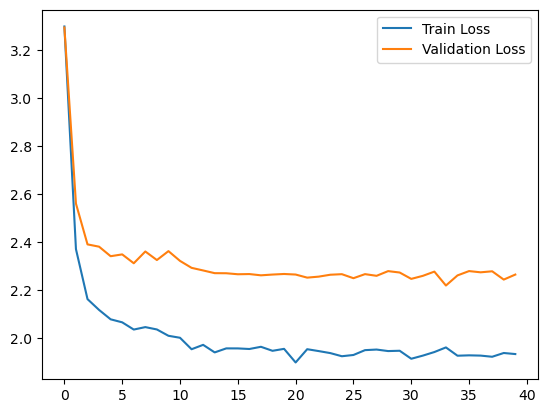

In [25]:
epochs = 10000
learning_rate = 0.0001

for epoch in range(epochs):

    # Minibatch
    ix = torch.randint(Xtr.shape[0], size=(minibatch_size,), device=default_device, generator=g)
    X, Y = Xtr[ix], Ytr[ix]

    # Forward Pass
    model.train()
    logits = model(X)

    # Loss 
    loss = F.cross_entropy(logits, Y)
    if epoch % 1000 == 0:
        model.eval()
        lossi_tr.append(M.estimateError(Xtr, Ytr, model))
        lossi_cv.append(M.estimateError(Xcv, Ycv, model))
        print(f"Epoch:{epoch} Training Loss: {lossi_tr[-1]}\t Validation Loss:{lossi_cv[-1]}")
        model.train()

    # Zero Grad
    for p in model.parameters():
        p.grad = None

    # Backward Pass
    loss.backward()
    
    # Update Weight
    for p in model.parameters():
        p.data -= learning_rate * p.grad

plt.plot(lossi_tr, label="Train Loss")
plt.plot(lossi_cv, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()

In [26]:
words = M.generate(model, 
                 encode_func=encode, 
                 decode_func=decode, 
                 start_ch=".", 
                 context_length=context_length, 
                 count=10, 
                 max_char=10,
                 d=default_device)

words

['krayn',
 'sathrry',
 'tillina',
 'haleel',
 'getten',
 'alleena',
 'asia',
 'ziyand',
 'lillyanna',
 'emila']